In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

## first function loads a chunk of the data, per_cluster is the variable usedd here, that is the amount loaded per cluster

## the second function loads all the data but takes really really long

## third function takes random data_sample from file

In [16]:
per_cluster = 50

data = pd.read_csv('bio_train.csv', header=None)  
filtered_data = data.groupby(0).apply(lambda x: x.head(per_cluster)).reset_index(drop=True)

# Now 'filtered_data' contains 10 entries for each BLOCK ID
X = filtered_data.iloc[:, 3:].values  # Feature columns
true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\Alexm\AppData\Local\Temp\ipykernel_20712\2366285504.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = data.groupby(0).apply(lambda x: x.head(50)).reset_index(drop=True)


In [13]:
# Let's reload the entire dataset without filtering it to 40 entries per group
# and without assuming there is no header.

# Load the full data again from the CSV file, assuming there's a header
full_data = pd.read_csv('bio_train.csv')

# We will consider all rows this time, without filtering by groups
# Setting the first column as labels and the rest as features
full_true_labels = full_data.iloc[:, 0].values  # True labels
full_X = full_data.iloc[:, 1:].values  # Feature columns

# Normalize the full features
full_scaler = StandardScaler()
full_X_scaled = full_scaler.fit_transform(full_X)

# Displaying the shapes of labels and features to confirm the loading
full_true_labels.shape, full_X_scaled.shape
print(full_true_labels.shape, full_X_scaled.shape)

X = full_X_scaled
X_scaled = full_X_scaled
true_labels = full_true_labels

(145749,) (145749, 76)


In [24]:
# Let's reload the entire dataset without filtering it to 40 entries per group
# and without assuming there is no header.

# Load the full data again from the CSV file, assuming there's a header
full_data = pd.read_csv('bio_train.csv')

# We will consider all rows this time, without filtering by groups
# Setting the first column as labels and the rest as features
full_true_labels = full_data.iloc[:, 0].values  # True labels
full_X = full_data.iloc[:, 1:].values  # Feature columns

# Normalize the full features
full_scaler = StandardScaler()
full_X_scaled = full_scaler.fit_transform(full_X)



X = full_X_scaled
X_scaled = full_X_scaled
true_labels = full_true_labels

# shuffle and select 10% of the data, however keep x and y together
np.random.seed(0)
shuffle = np.random.permutation(len(X))
X = X[shuffle]
true_labels = true_labels[shuffle]

# use 5% of the data
X = X[:len(X) // 20]
true_labels = true_labels[:len(true_labels) // 20]

X_scaled = X


print(true_labels.shape, X_scaled.shape)

(7287,) (7287, 76)


#  Lloyd’s algorithm for k-Means Clustering 

In [26]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [27]:
k = 153
max_iters = 1000

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans(X_scaled, k, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

K-means Iteration:   0%|          | 4/1000 [00:03<13:57,  1.19it/s]


KeyboardInterrupt: 

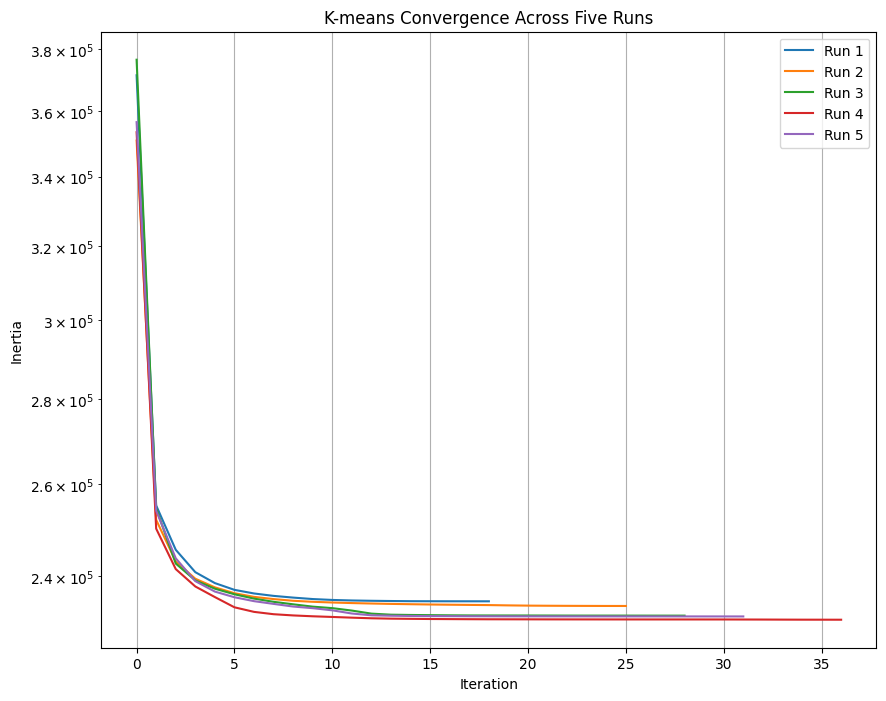

In [ ]:
plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

Average NMI Score over five runs: 0.3548


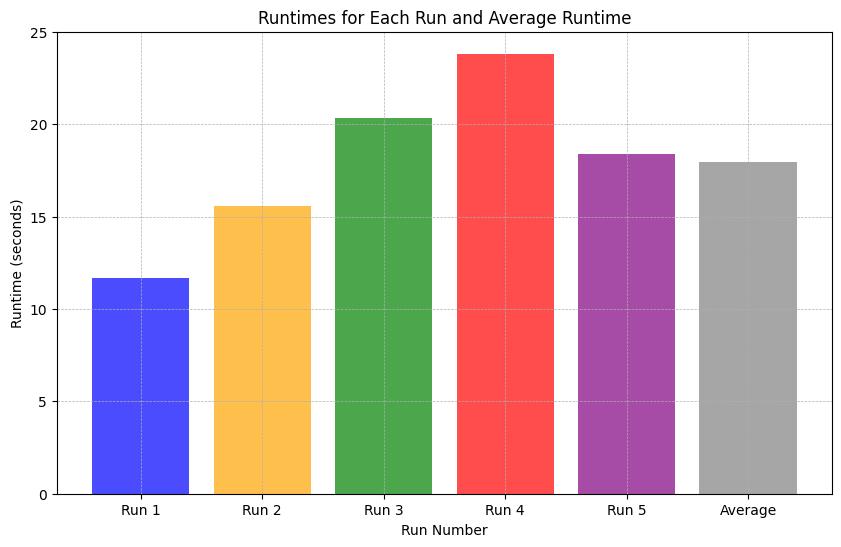

In [ ]:
# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



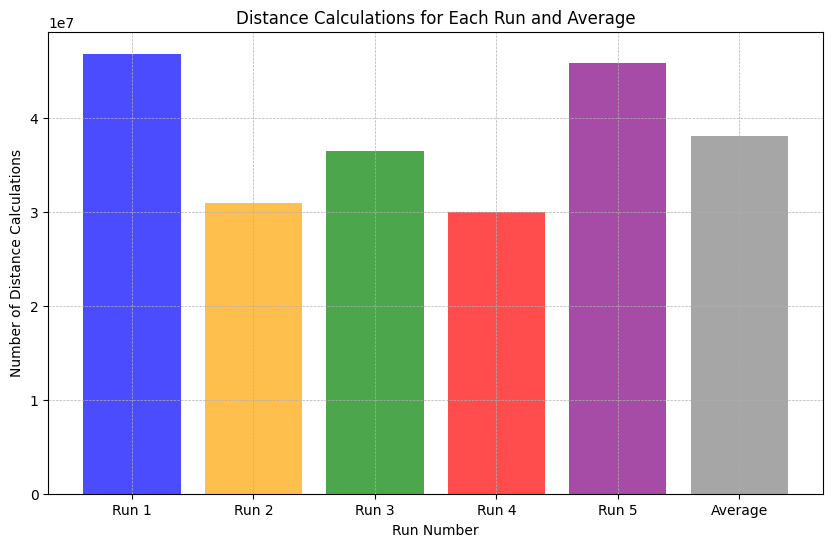

In [ ]:
# Assuming `all_distance_calculations` contains the number of distance calculations for each of the five runs
# Distance calculations data and calculation of average
average_distances = np.mean(all_distance_calculations)

# Create a plot for distance calculations with custom colors
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), all_distance_calculations + [average_distances], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Number of Distance Calculations')
plt.title('Distance Calculations for Each Run and Average')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

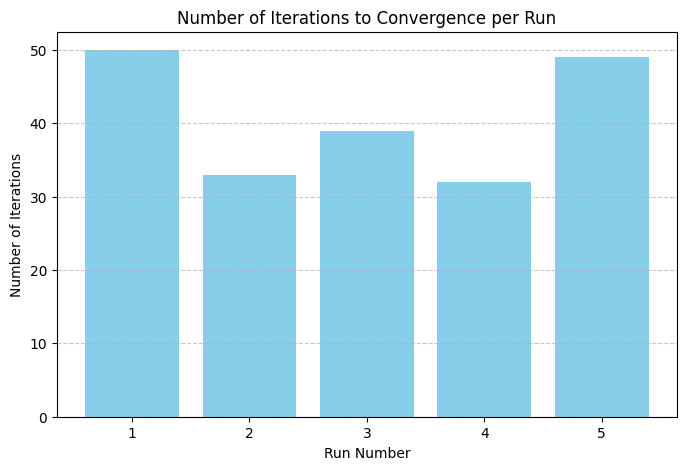

In [ ]:
plt.figure(figsize=(8, 5))
runs = list(range(1, len(all_num_itertations) + 1))
plt.bar(runs, all_num_itertations, color='skyblue')

plt.title('Number of Iterations to Convergence per Run')
plt.xlabel('Run Number')
plt.ylabel('Number of Iterations')
plt.xticks(runs)  # Ensures each run is labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

K-means Iteration: 100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


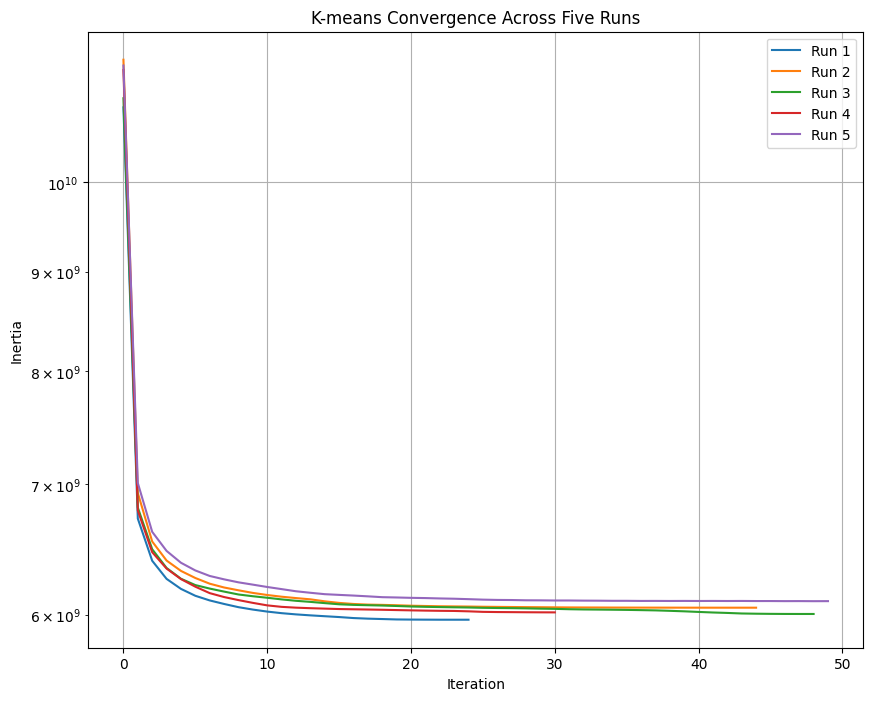

Average NMI Score over five runs: 0.3415


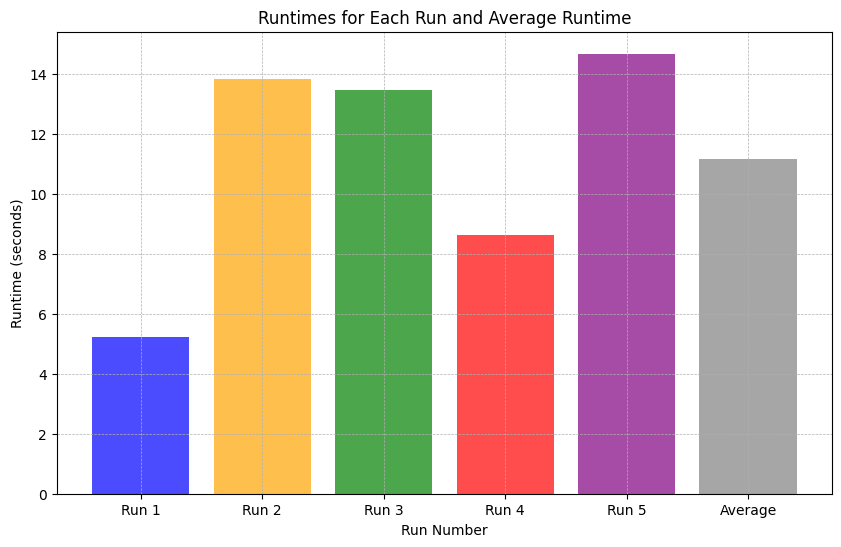

In [7]:
import numpy as np
from tqdm import tqdm
import time

# Define the LSH function
def lsh_hash_function(a, b, w):
    def hash_func(p):
        return np.floor((np.dot(a, p) + b) / w)
    return hash_func

# Initialize LSH parameters
def initialize_lsh(X, num_hashes, w):
    n, d = X.shape
    a = np.random.randn(num_hashes, d)
    b = np.random.uniform(0, w, num_hashes)
    hash_funcs = [lsh_hash_function(a[i], b[i], w) for i in range(num_hashes)]
    return hash_funcs

# Compute hash values for all data points
def compute_lsh_hashes(X, hash_funcs):
    hashes = np.array([[h(p) for h in hash_funcs] for p in X])
    return hashes

# Custom K-means functions
def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters_lsh(X, centroids, hashes, hash_funcs):
    n_samples = X.shape[0]
    labels = np.empty(n_samples, dtype=int)
    
    # Compute centroid hashes
    centroid_hashes = compute_lsh_hashes(centroids, hash_funcs)
    
    for i, point_hash in enumerate(hashes):
        # Check which centroids share the same hash value
        potential_centroids = np.all(centroid_hashes == point_hash, axis=1)
        if np.any(potential_centroids):
            distances = np.sqrt(((X[i] - centroids[potential_centroids])**2).sum(axis=1))
            labels[i] = np.argmin(distances)
        else:
            # If no hash match, fall back to calculating distances to all centroids
            distances = np.sqrt(((X[i] - centroids)**2).sum(axis=1))
            labels[i] = np.argmin(distances)
    
    return labels

def update_centroids(X, labels, k):
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids

def kmeans_lsh(X, k, num_hashes=10, w=4.0, max_iters=500):
    centroids = initialize_centroids(X, k)
    hash_funcs = initialize_lsh(X, num_hashes, w)
    hashes = compute_lsh_hashes(X, hash_funcs)
    
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters_lsh(X, centroids, hashes, hash_funcs)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 50

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_lsh(X, k, num_hashes=25, w=4.0, max_iters=max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



K-means Iteration:  36%|███▌      | 18/50 [00:02<00:04,  6.89it/s]


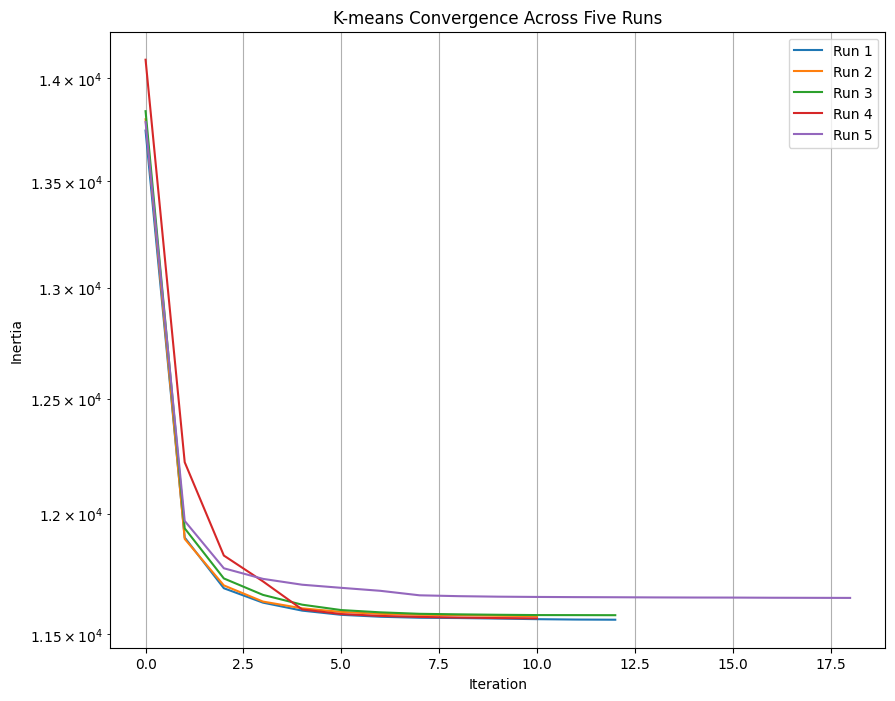

Average NMI Score over five runs: 0.3156


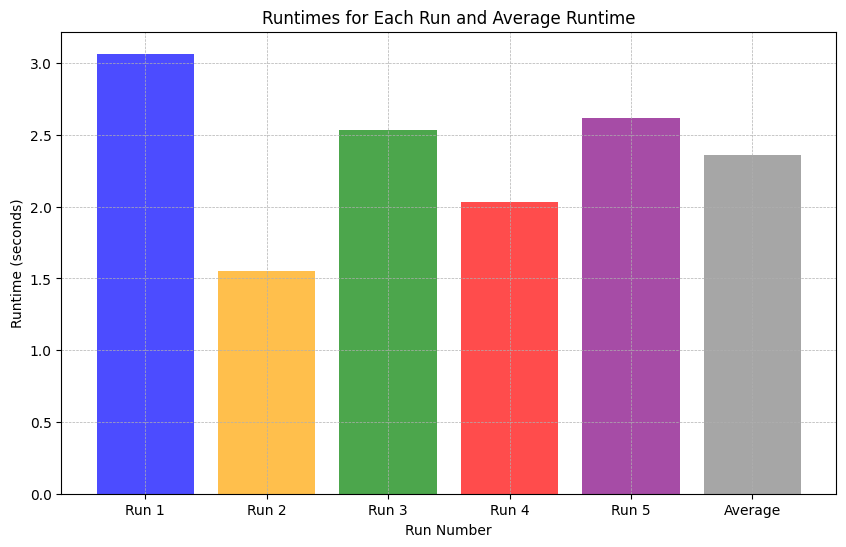

In [30]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def sample_coreset(X, k, m):
    # Simple random sampling for coreset
    indices = np.random.choice(X.shape[0], size=m, replace=False)
    return X[indices], np.ones(m) / m

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        weighted_points = X[labels == i] * weights[labels == i, np.newaxis]
        centroids[i] = weighted_points.sum(axis=0) / weights[labels == i].sum()
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        raise ValueError(f"Coreset size {coreset_size} must be at least as large as k {k}.")
    
    start_time = time.time()
    # Step 1: Sample the coreset
    coreset, weights = sample_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime


# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 50

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k,2000, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def sample_coreset(X, k, m):
    # Simple random sampling for coreset
    indices = np.random.choice(X.shape[0], size=m, replace=False)
    return X[indices], np.ones(m) / m

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if weights[cluster_indices].sum() > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            # Reinitialize the centroid to a random data point
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        raise ValueError(f"Coreset size {coreset_size} must be at least as large as k {k}.")
    
    start_time = time.time()
    # Step 1: Sample the coreset
    coreset, weights = sample_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime


# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 50

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k,2000, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()